In [1]:
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer
from tomoSegmentPipeline.showcaseResults import load_model as _load_model
from tomoSegmentPipeline.dataloader import tomoSegment_dataset
from tomoSegmentPipeline.losses import Tversky_index, Tversky_loss, Tversky1_loss


from torch.utils.data import DataLoader
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tqdm import tqdm

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
train_tomos = ['tomo02', 'tomo03', 'tomo17']
val_tomos = ['tomo32', 'tomo10']
input_type = 'cryoCARE'

nPatches_training = 32


paths_trainData, paths_trainTarget = setup.get_paths(train_tomos, input_type)
paths_valData, paths_valTarget = setup.get_paths(val_tomos, input_type)

if nPatches_training is not None:
    # training with tomo02, 03 and 17 yields 32 patches in total.
    assert nPatches_training<=len(paths_trainData)
    # this guarantees that we always use the same incremental list of random patches
    random.seed(17)
    random_indices = random.sample(range(len(paths_trainData)), len(paths_trainData))[0:nPatches_training]

    print('Random indices used for training: ', random_indices)
    paths_trainData = list(np.array(paths_trainData)[random_indices])
    paths_trainTarget = list(np.array(paths_trainTarget)[random_indices])
    
train_patchCounts = [x.split('/')[-1].split('_')[0] for x in paths_trainData]
train_patchCounts = np.unique(train_patchCounts, return_counts=True)
train_patchCounts = dict(zip(*train_patchCounts))

val_patchCounts = [x.split('/')[-1].split('_')[0] for x in paths_valData]
val_patchCounts = np.unique(val_patchCounts, return_counts=True)
val_patchCounts = dict(zip(*val_patchCounts))

train_patchCounts

Random indices used for training:  [26, 25, 9, 11, 29, 5, 24, 22, 30, 17, 21, 8, 3, 0, 7, 12, 13, 4, 15, 20, 31, 10, 6, 2, 18, 1, 27, 28, 14, 19, 23, 16]


{'tomo02': 10, 'tomo03': 12, 'tomo17': 10}

# Incremental model best validation scores analysis

In [25]:
logs_path = PARENT_PATH + 'data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in tqdm(list(logs_path.rglob('*/version_*/'))):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        n_patches = model_file_split[-3]
        n_patches = int(n_patches.replace('nPatches_', ''))
        
        name, input_type, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, input_type, epochs_str, patch_size, n_patches, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        print(f)

 72%|██████████████████████████▊          | 121/167 [00:29<00:17,  2.69it/s]

/home/ubuntu/Thesis/data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/isoNET/train02-03-17/nPatches_28/version_3


100%|█████████████████████████████████████| 167/167 [00:39<00:00,  4.19it/s]


In [26]:
df_incremental = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'n_patches', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])

df_incremental = df_incremental[df_incremental.n_patches%4==0].sort_values(['input_type', 'n_patches'])
df_incremental = df_incremental[df_incremental.patch_size=='in84']

print(df_incremental.shape)
df_incremental.head()

(166, 9)


,name,input_type,epochs,patch_size,n_patches,lr,version,best_val_loss_epoch,associated_val_class1_dice
6,Baseline,F2Fd,118 out of 1000,in84,4,lr0.000100,v0,1.033128,0.094308
7,Baseline,F2Fd,273 out of 1000,in84,4,lr0.000100,v1,0.456145,0.592800
14,Baseline,F2Fd,447 out of 1000,in84,8,lr0.000100,v0,0.239714,0.792739
15,Baseline,F2Fd,254 out of 1000,in84,8,lr0.000100,v1,0.325548,0.713967
0,Baseline,F2Fd,296 out of 1000,in84,12,lr0.000100,v0,0.280483,0.754092


In [69]:
loss_means = df_incremental[df_incremental.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'best_val_loss_epoch':['mean','std','count'], 
                                                                'associated_val_class1_dice':['mean','std']}).reset_index()
loss_means.columns = ['_'.join(col) for col in loss_means.columns]

loss_means.head()

,input_type_,n_patches_,best_val_loss_epoch_mean,best_val_loss_epoch_std,best_val_loss_epoch_count,associated_val_class1_dice_mean,associated_val_class1_dice_std
0,F2Fd,4,0.744637,0.407989,2,0.343554,0.352487
1,F2Fd,8,0.282631,0.060694,2,0.753353,0.055700
2,F2Fd,12,0.262820,0.024979,2,0.770537,0.023257
3,F2Fd,16,0.245682,0.002091,2,0.785896,0.002012
4,F2Fd,20,0.216508,0.000472,2,0.811738,0.000129


In [70]:
loss_means[['input_type_', 'n_patches_', 'best_val_loss_epoch_count']].drop_duplicates()

,input_type_,n_patches_,best_val_loss_epoch_count
0,F2Fd,4,2
1,F2Fd,8,2
2,F2Fd,12,2
3,F2Fd,16,2
4,F2Fd,20,2
5,F2Fd,24,2
6,F2Fd,28,2
7,F2Fd,32,2
8,cryoCARE,4,5
9,cryoCARE,8,5


Text(0.5, 1.0, 'Standard deviation by number of input patches per input type')

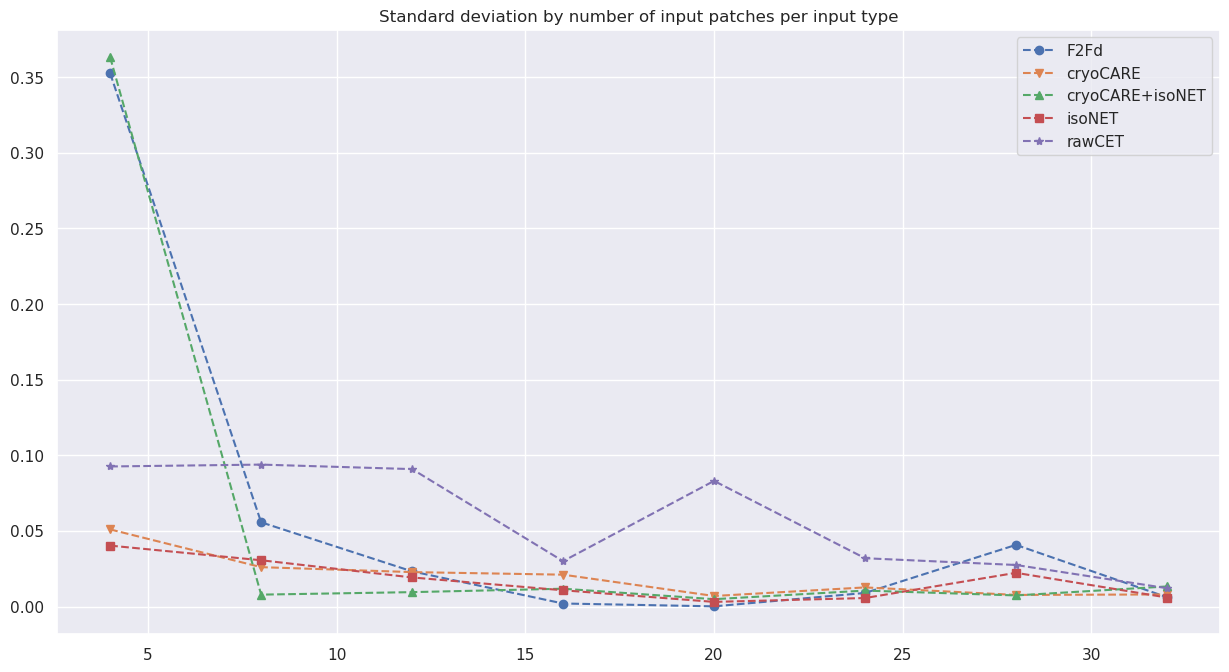

In [71]:
plt.figure(dpi=100)
sns.set(rc = {'figure.figsize':(15,8)})
markers = ['o', 'v', '^', 's', '*']
count = 0
for i, g in loss_means.set_index('n_patches_').groupby('input_type_'):
    g = g.reset_index()
    plt.plot(g['n_patches_'], g['associated_val_class1_dice_std'], label=i, marker=markers[count], linestyle='dashed')
    plt.legend()
    count+=1
    
plt.title('Standard deviation by number of input patches per input type')

Text(0.5, 1.0, 'Dice score for test patches as a function of the number of training patches per input type')

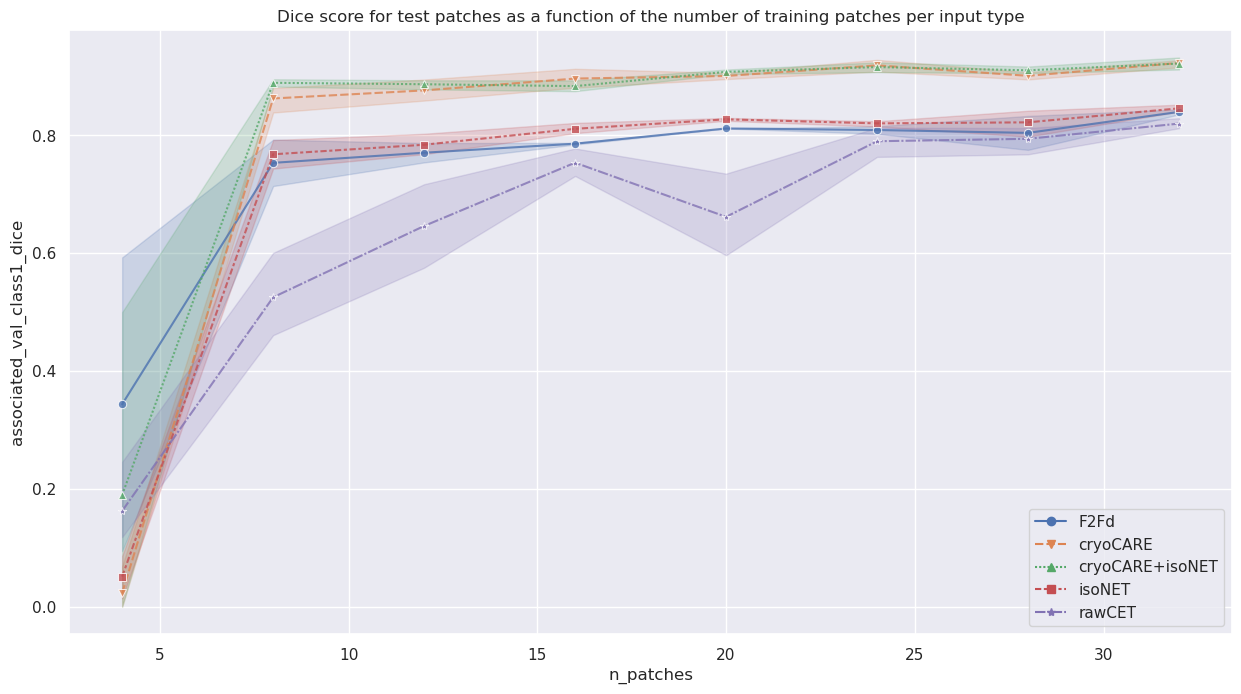

In [74]:
plt.figure(dpi=100)
sns.lineplot(x='n_patches', y='associated_val_class1_dice', hue='input_type', data=df_incremental, style='input_type', markers=markers, alpha=0.8)
plt.legend(loc='lower right')
plt.title('Dice score for test patches as a function of the number of training patches per input type')

# Incremental models Dice on test set

In [3]:
from tomoSegmentPipeline.showcaseResults import *
import yaml

def load_model(logdir, DataParallel=False):
    "Returns loaded model from checkpoint and hyperparameters"
    if not logdir.endswith("/"):
        logdir = logdir + "/"

    with open(glob(logdir + "hparams.yaml")[0]) as f:
        hparams = yaml.load(f, Loader=yaml.BaseLoader)

    # yaml is stupid
    with open(logdir + "hparams.yaml") as f:
        s = f.readlines()
    
    Nclass = int(hparams['Ncl'])
    lr = float(hparams['lr'])
    pretrain_type = hparams['pretrain_type']
    if pretrain_type=='null':
        pretrain_type=None
               
    weight_decay = hparams['weight_decay']
    
    model = DeepFinder_model(
        Nclass, Tversky_loss, lr, weight_decay, pretrain_type=pretrain_type
    )

    ckpt_file = glob(logdir + "checkpoints/*.ckpt")
    assert len(glob(logdir + "checkpoints/*.ckpt")) == 1
    ckpt_file = ckpt_file[0]

    model = model.load_from_checkpoint(ckpt_file).cuda()
    if DataParallel:
        model = torch.nn.DataParallel(model)

    return model, hparams

def compute_dice1_testSet(testLoader, model):

    dice1 = []
    for patch, labels in testLoader:
        patch, labels = patch.cuda(), labels.cuda()
        pred = model(patch).detach().cpu()
        val = float(Tversky_index(pred.cuda(), labels.cuda())[1])
        dice1.append(val)

    dice1 = np.array(dice1).mean()

    torch.cuda.empty_cache()
    
    return dice1

In [40]:
dim_in=84

test_tomos = ["tomo38", "tomo04"]

logs_path = PARENT_PATH + 'data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel'
logs_path = Path(logs_path)

model_info = []

flag_compute_testLoader = False
current_input_type = None

for f in tqdm(list(logs_path.rglob('version_*/'))):
    logdir_path = f.as_posix()
    if 'F2Fd' in logdir_path:
        continue
    
    model, hparams = load_model(logdir_path, True)
        
    model_file = glob(os.path.join(logdir_path, '*.model'))
    
    if len(model_file)==1:
        model_file_split = model_file[0].split('/')

        n_patches = model_file_split[-3]
        n_patches = int(n_patches.replace('nPatches_', ''))

        name, input_type, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        # only compute testLoader when we change input type
        if current_input_type is None:
            current_input_type = input_type
            flag_compute_testLoader = True
        if current_input_type!=input_type:
            flag_compute_testLoader = True
            current_input_type = input_type

        if flag_compute_testLoader:
            print('Computing TestLoader for input type %s' %input_type)
            paths_testData, paths_testTarget = setup.get_paths(test_tomos, input_type)

            test_set = tomoSegment_dataset(
                paths_testData, paths_testTarget, dim_in, hparams['Ncl'], 0, False
            )

            testLoader = DataLoader(test_set, batch_size=12)

            flag_compute_testLoader = False

        dice1 = compute_dice1_testSet(testLoader, model)

        model_info.append([name, input_type, epochs, patch_size, n_patches, lr, version, dice1])
    else:
        print(f)

  0%|                                               | 0/167 [00:00<?, ?it/s]

Computing TestLoader for input type cryoCARE+isoNET


 34%|████████████▋                         | 56/167 [03:58<10:54,  5.89s/it]

Computing TestLoader for input type cryoCARE


 57%|█████████████████████▊                | 96/167 [07:55<06:51,  5.80s/it]

Computing TestLoader for input type isoNET


 72%|██████████████████████████▊          | 121/167 [10:25<04:37,  6.04s/it]

/home/ubuntu/Thesis/data/membraneSegmentation/model_logs/incremental_models/logs/BaselineModel/isoNET/train02-03-17/nPatches_28/version_3


 76%|████████████████████████████▏        | 127/167 [10:54<03:36,  5.41s/it]

Computing TestLoader for input type rawCET


100%|█████████████████████████████████████| 167/167 [15:07<00:00,  5.43s/it]


In [41]:
df_testSet = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'n_patches', 'lr', 'version', 'dice1'])

df_testSet = df_testSet[df_testSet.n_patches%4==0].sort_values(['input_type', 'n_patches'])
df_testSet = df_testSet[df_testSet.patch_size=='in84']

print(df_testSet.shape)
df_testSet.head()

(150, 8)


,name,input_type,epochs,patch_size,n_patches,lr,version,dice1
55,Baseline,cryoCARE,1000,in84,4,lr0.000100,v4,3.343361e-07
56,Baseline,cryoCARE,1000,in84,4,lr0.000100,v2,4.481014e-08
57,Baseline,cryoCARE,1000,in84,4,lr0.000100,v0,1.361458e-07
58,Baseline,cryoCARE,1000,in84,4,lr0.000100,v3,1.990933e-07
59,Baseline,cryoCARE,1000,in84,4,lr0.000100,v1,5.207713e-08


In [42]:
loss_means = df_testSet[df_testSet.n_patches%4==0].groupby(['input_type', 'n_patches']).agg({'dice1':['mean','std','count']
                                                                                            }).reset_index()
loss_means.columns = ['_'.join(col) for col in loss_means.columns]

loss_means.head()

,input_type_,n_patches_,dice1_mean,dice1_std,dice1_count
0,cryoCARE,4,1.532925e-07,1.195632e-07,5
1,cryoCARE,8,8.098958e-01,3.371648e-02,5
2,cryoCARE,12,8.368031e-01,2.570207e-02,5
3,cryoCARE,16,8.685633e-01,3.109250e-02,5
4,cryoCARE,20,8.749956e-01,1.830540e-02,5


In [43]:
loss_means[['input_type_', 'n_patches_', 'dice1_count']].drop_duplicates()

,input_type_,n_patches_,dice1_count
0,cryoCARE,4,5
1,cryoCARE,8,5
2,cryoCARE,12,5
3,cryoCARE,16,5
4,cryoCARE,20,5
5,cryoCARE,24,5
6,cryoCARE,28,4
7,cryoCARE,32,5
8,cryoCARE+isoNET,4,5
9,cryoCARE+isoNET,8,5


Text(0.5, 1.0, 'Standard deviation by number of input patches per input type')

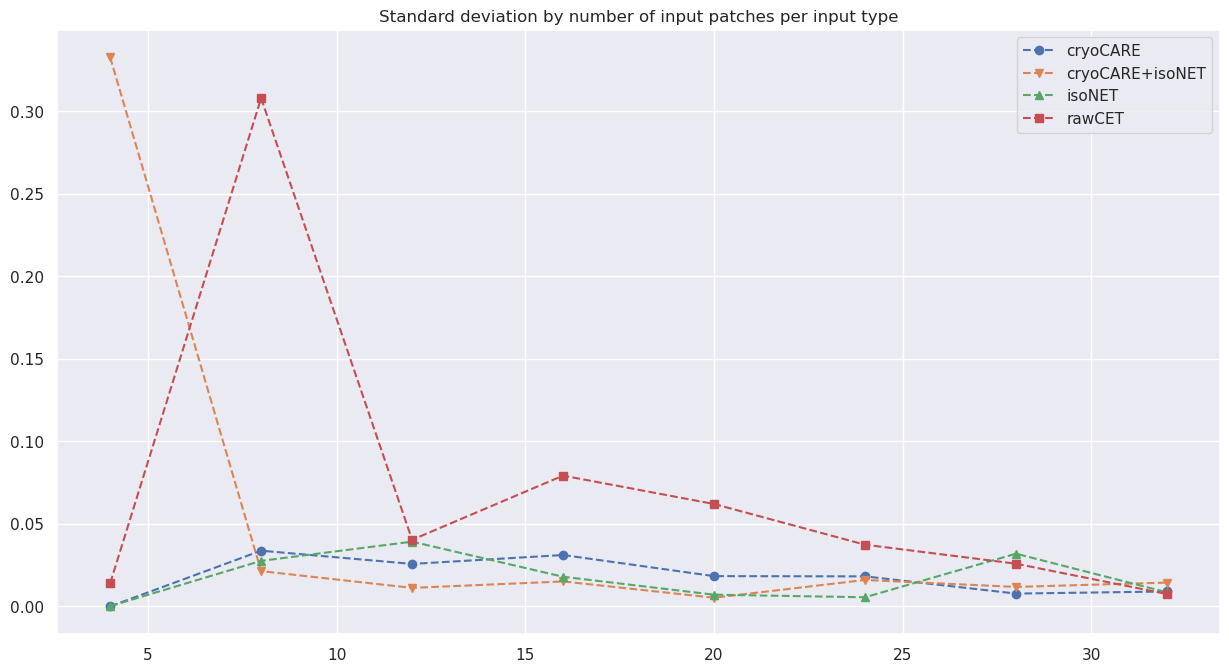

In [56]:
plt.figure(dpi=100)
sns.set(rc = {'figure.figsize':(15,8)})
markers = ['o', 'v', '^', 's', '*']
count = 0
for i, g in loss_means.set_index('n_patches_').groupby('input_type_'):
    g = g.reset_index()
    plt.plot(g['n_patches_'], g['dice1_std'], label=i, marker=markers[count], linestyle='dashed')
    plt.legend()
    count+=1
    
plt.title('Standard deviation by number of input patches per input type')

Text(0.5, 1.0, 'Dice score for test patches as a function of the number of training patches per input type')

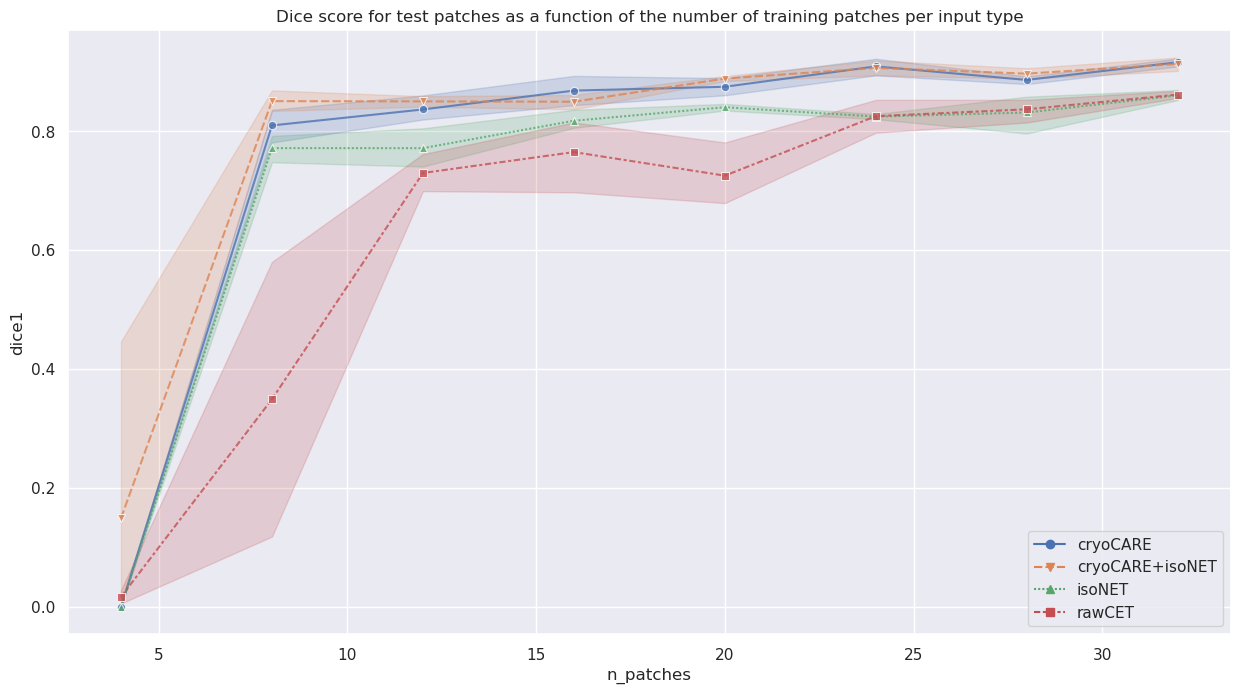

In [68]:
plt.figure(dpi=100)
sns.lineplot(x='n_patches', y='dice1', hue='input_type', data=df_testSet, style='input_type', markers=markers[0:4], alpha=0.8)
plt.legend(loc='lower right')
plt.title('Dice score for test patches as a function of the number of training patches per input type')

# Mean best dice predictions Baseline Models

In [21]:
logs_path = PARENT_PATH + 'models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass

In [13]:
df_model = pd.DataFrame(model_info, columns=['name', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(18, 8)


,name,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816
1,Baseline,rawCET,1000 out of 1000,in84,lr0.000100,v1,0.274763,0.760572
2,Baseline,rawCET,346 out of 1000,in96,lr0.000100,v4,0.289667,0.730407
3,Baseline,rawCET,393 out of 1000,in96,lr0.000100,v3,0.253714,0.765400
4,Baseline,rawCET,301 out of 1000,in56,lr0.000100,v2,0.231046,0.789884


In [15]:
df_model[['name', 'input_type', 'version']].drop_duplicates()

,name,input_type,version
0,Baseline,rawCET,v0
1,Baseline,rawCET,v1
2,Baseline,rawCET,v4
3,Baseline,rawCET,v3
4,Baseline,rawCET,v2
5,Baseline,cryoCARE+isoNET,v0
6,Baseline,cryoCARE+isoNET,v1
7,Baseline,cryoCARE+isoNET,v3
8,Baseline,cryoCARE+isoNET,v2
9,Baseline,isoNET,v0


<AxesSubplot:xlabel='input_type', ylabel='associated_val_class1_dice'>

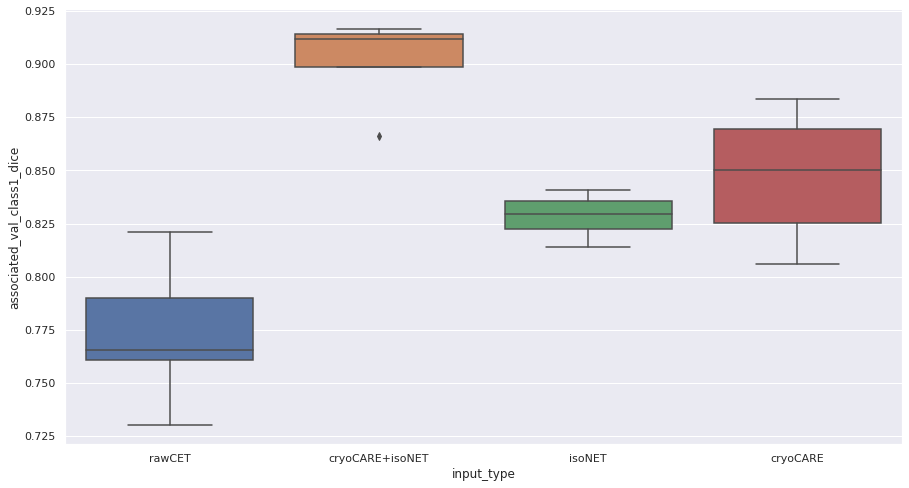

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_model)

# Mean best dice predictions for LowBaseline Models

In [31]:
logs_path = PARENT_PATH + 'models_1/logs/LowBaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        train_tomo = model_file_split[-3]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        train_set = str(train_patchCounts)[1:-1].replace(',', ' ')
        train_set = train_set.replace(',', ' -').replace("'", "")

        validation_set = str(val_patchCounts)[1:-1].replace(',', ' ')
        validation_set = validation_set.replace(',', ' -').replace("'", "")

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, train_tomo, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass

In [32]:
df_model = pd.DataFrame(model_info, columns=['name', 'train_tomo', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(54, 9)


,name,train_tomo,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,LowBaseline,train17,rawCET,107 out of 1000,in84,lr0.000300,v0,0.773063,0.295680
1,LowBaseline,train17,rawCET,183 out of 1000,in84,lr0.000100,v1,0.783792,0.295086
2,LowBaseline,train17,rawCET,138 out of 1000,in96,lr0.000100,v4,0.778582,0.285223
3,LowBaseline,train17,rawCET,446 out of 1000,in96,lr0.000100,v3,0.710688,0.334793
4,LowBaseline,train17,rawCET,292 out of 1000,in56,lr0.000100,v2,0.734075,0.314304


In [37]:
df_model[['train_tomo', 'input_type', 'version']].drop_duplicates()

,train_tomo,input_type,version
0,train17,rawCET,v0
1,train17,rawCET,v1
2,train17,rawCET,v4
3,train17,rawCET,v3
4,train17,rawCET,v2
5,train02,rawCET,v0
6,train02,rawCET,v1
7,train02,rawCET,v4
8,train02,rawCET,v3
9,train02,rawCET,v2


<AxesSubplot:xlabel='input_type', ylabel='associated_val_class1_dice'>

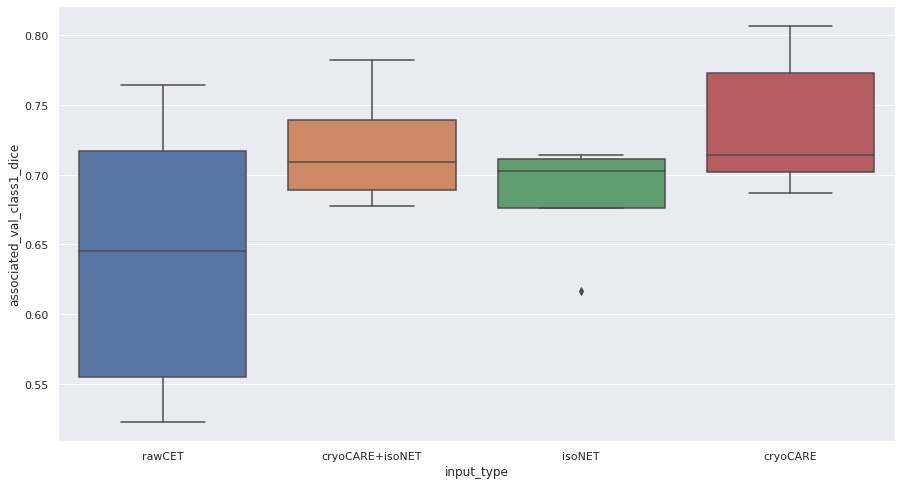

In [35]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='input_type', y='associated_val_class1_dice', data=df_model[df_model.train_tomo=='train02'])

In [ ]:
# isolated analysis depending on reconstruction (denoising) process